Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  print('Found and verified %s' % filename)
  print(statinfo.st_size)
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip
0


In [3]:
filename = 'text8 .zip'

Read the data into a string.

In [4]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [26]:
words[:9]
exp = words[:9]
exp[0] = 'a'
exp[1] = 'as'
print(exp)
collections.Counter(exp).most_common(3)
#hence this functions returns the most common n workds with their counter

['a', 'as', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']


[('as', 2), ('a', 2), ('first', 1)]

In [27]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5241, 3082, 12, 6, 195, 2, 3134, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [7]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window

  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)

  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'a', 'originated', 'term', 'originated', 'term', 'as', 'of']


Train a skip-gram model.

In [36]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [9]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.334339
Nearest to often: mit, betrayal, akin, proverbial, organs, guilford, heroes, humbert,
Nearest to has: parodies, competitive, erupting, fethry, virology, positioning, constructible, tinted,
Nearest to state: fermilab, griffiths, bukovina, dazzling, flexible, bronfman, teamwork, alkanes,
Nearest to were: saddle, hne, queues, considering, bonfires, environmentalist, agust, compound,
Nearest to will: couch, bunker, milt, juniors, visualisation, skates, differs, describing,
Nearest to by: rove, cycorp, wits, golda, appraisal, caso, streamlining, ceremonies,
Nearest to one: trains, guaranteed, toys, concentrate, redskins, monastery, striker, warwick,
Nearest to be: bostonians, diaphragm, aye, rbi, mandaic, contraceptives, mccormick, verses,
Nearest to years: excessive, intercourse, kaist, masefield, folketing, dubuque, densest, fondness,
Nearest to called: chopin, grasshoppers, hermaphroditus, phenomenological, hayt, math, bootleg, intercontinenta

Average loss at step 52000: 3.437781
Average loss at step 54000: 3.419415
Average loss at step 56000: 3.441624
Average loss at step 58000: 3.395356
Average loss at step 60000: 3.393514
Nearest to often: usually, commonly, sometimes, generally, now, also, widely, still,
Nearest to has: had, have, was, is, creoles, contains, having, makes,
Nearest to state: government, denunciation, city, court, cheers, states, finding, cambridge,
Nearest to were: are, was, had, have, be, those, been, incompatibilities,
Nearest to will: would, should, can, may, could, must, cannot, might,
Nearest to by: through, gauguin, when, was, as, from, wits, suspends,
Nearest to one: four, eight, two, nine, six, three, seven, five,
Nearest to be: been, was, were, is, have, become, being, are,
Nearest to years: days, months, year, decades, weeks, xilinx, times, seconds,
Nearest to called: moto, dogmatically, showers, norsk, nominal, fumble, gaon, used,
Nearest to b: d, c, j, h, p, r, f, t,
Nearest to s: oxfordshire,

In [10]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

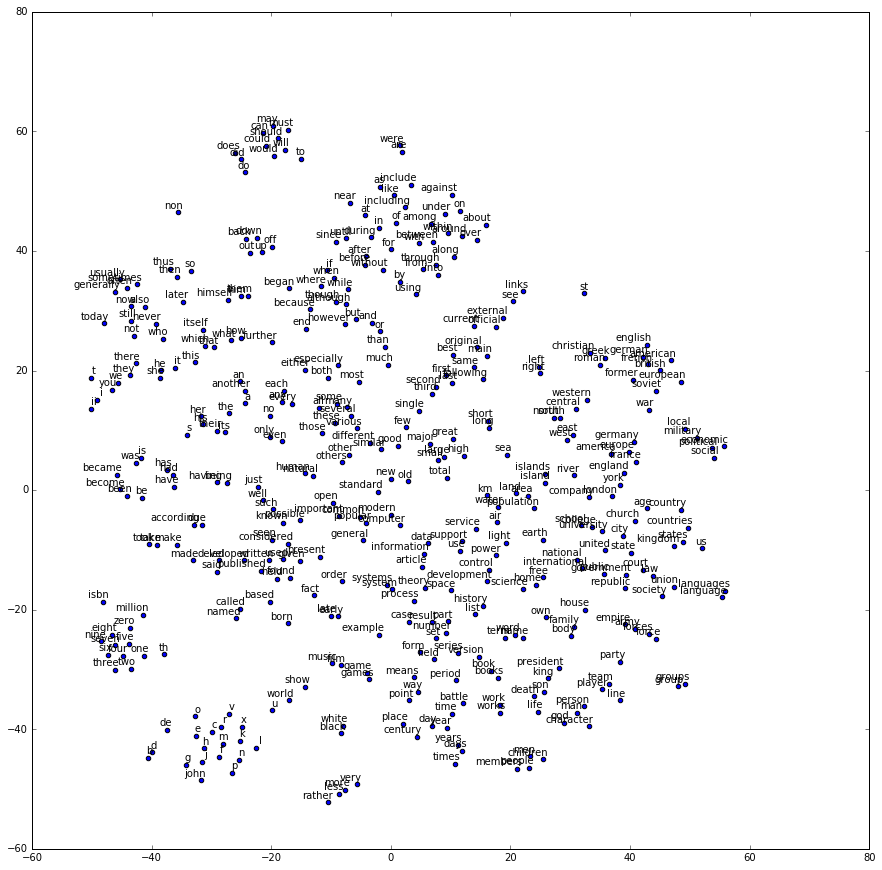

In [12]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [37]:
params = tf.constant([[10,20,30,40],[100,200,300,400],[1,2,3,4]])
ids = tf.constant([[1,1,0],[1,1,2]])
embeddingsTest = tf.reduce_sum(tf.nn.embedding_lookup(params,ids),1)/(2*skip_window)
#embeddingsTest = tf.Variable(tf.random_uniform([4, 1], -1.0, 1.0))
init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    print (sess.run(embeddingsTest)) 

[[105.  210.  315.  420. ]
 [100.5 201.  301.5 402. ]]


In [39]:
print(ids.get_shape())

(2, 3)


In [40]:
data_index = 0

# the length of deque determines that the newly added data will replace the oldest data in a queue fashion
# CBOW model update, generate_batch function needs some cleaning, however, in order to keep the function signature, 
# I didn't remove num_skips.
#   -2, -1 , 0, 1, 2; 0 is label, -2, -1, 1, 2 are a group of train context when skip_window is 2
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size,2*skip_window), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    #print(buffer)
  for i in range(batch_size):
    target = skip_window  # target label at the center of the buffer
    #targets_to_avoid = [ skip_window ]
    train_context= []
    for j in range(skip_window):
      train_context.append(buffer[skip_window-j-1])
    for j in range(skip_window):
      train_context.append(buffer[skip_window+j+1])
      #while target in targets_to_avoid:
      #  target = random.randint(0, span - 1)
      #targets_to_avoid.append(target)
      #batch[i * num_skips + j] = buffer[skip_window]
      #labels[i * num_skips + j, 0] = buffer[target]
    labels[i] = buffer[skip_window]
    batch[i] = train_context
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    #print(buffer)
    #print(labels)
    #print(batch)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']


In [41]:
for num_skips, skip_window in [(2, 1)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    #print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print(batch)
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])


with num_skips = 2 and skip_window = 1:
[[5241   12]
 [3082    6]
 [  12  195]
 [   6    2]
 [ 195 3134]
 [   2   46]
 [3134   59]
 [  46  156]]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']


In [42]:
# CBOW , the world is label, context as the train, 
# 

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  #CBOW model, train is 2D matrix
  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size,2*skip_window])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # CBOW Model.
  # take the average of the context embeddings
  embed = tf.reduce_sum(tf.nn.embedding_lookup(embeddings, train_dataset),1)/(2*skip_window)
  # Compute the softmax loss, using a sample of the negative labels each time. 
    # and treat others as they don't appear , details in Udacity Lesson 5, clip 7
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  # embedding: 50000x128, after embedding_lookup, it is 64*128
  # call similarity, is that, 64*128  *  128*50000 matmul, is to only calcluate 64 rows of similarity to the others
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [43]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.735795
Nearest to seven: pressurised, transparent, bautista, shabbat, potter, presley, kraepelin, food,
Nearest to while: organisms, moraines, lbs, steel, suzhou, bolger, extending, pra,
Nearest to nine: stonework, auld, majored, tei, registry, prophesy, durkheim, musician,
Nearest to can: breathing, adoration, lorentz, weizenbaum, tay, icq, motorsport, conforms,
Nearest to world: ozark, cobe, archiving, kenji, solicitation, mat, rows, boisbaudran,
Nearest to these: wikimedia, itu, cerium, suffragist, ciii, instructors, shackleton, patten,
Nearest to so: dehydration, cautioned, delegation, microeconomics, roms, analogously, theseus, hannibal,
Nearest to were: planetarium, ulcers, lamo, smash, abide, blank, posen, worries,
Nearest to his: corrie, comforted, viper, marxist, banknote, cellphone, romita, shipowner,
Nearest to also: trough, contour, crystals, valkyrie, overworked, lysosome, varnothing, categorizing,
Nearest to their: tapestry, overcomin

Average loss at step 52000: 2.885838
Average loss at step 54000: 2.859502
Average loss at step 56000: 2.860716
Average loss at step 58000: 2.769923
Average loss at step 60000: 2.824052
Nearest to seven: six, eight, five, nine, four, three, zero, two,
Nearest to while: although, when, though, however, after, if, before, drugged,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to can: could, may, will, would, must, might, should, cannot,
Nearest to world: country, solicitation, caribbean, boisbaudran, inklings, anchovies, erode, congregationalists,
Nearest to these: several, such, various, those, many, some, all, different,
Nearest to so: yankees, oem, jones, mckeon, argued, rejoined, omitting, nva,
Nearest to were: are, have, was, had, been, be, vietnamese, fry,
Nearest to his: her, their, my, its, your, our, the, s,
Nearest to also: now, still, generally, usually, often, sometimes, never, typically,
Nearest to their: its, his, her, our, your, my, the, whose,
N

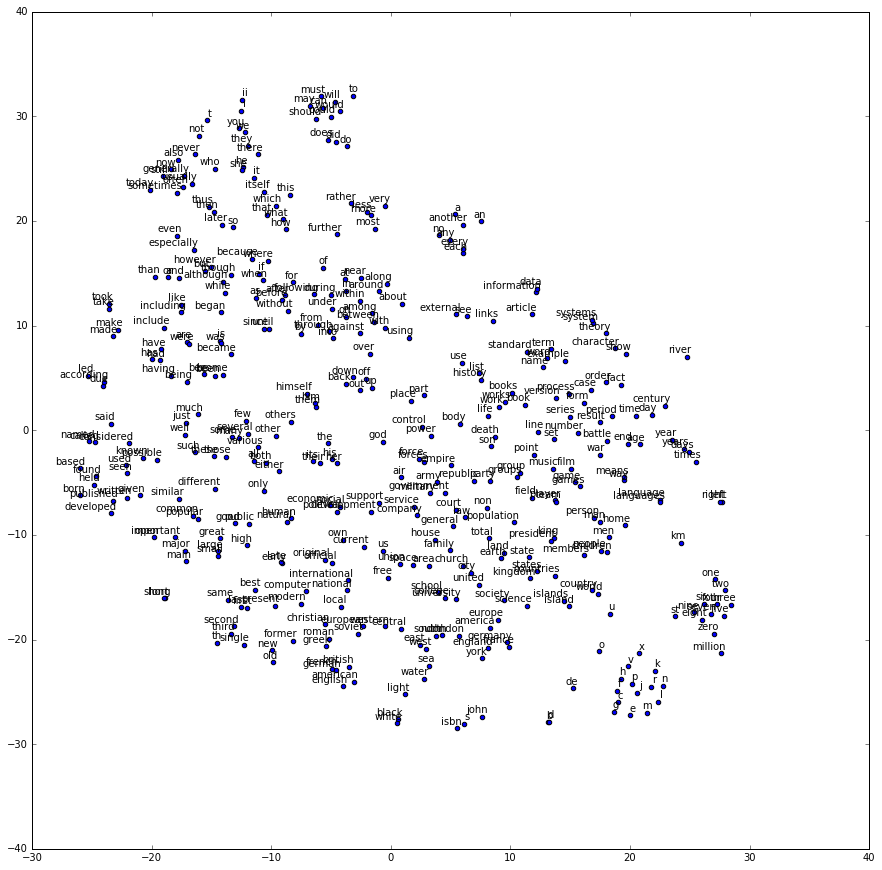

In [45]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)